[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

Install the wormpose package if needed.

In [1]:
!pip install --upgrade wormpose

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.9/22.9 MB 72.0 MB/s eta 0:00:00


If using Google Colab, please **restart the runtime** after installing the package: menu "Runtime" > "Restart runtime".

You can also select a GPU node for faster training: menu "Runtime" > "Change Runtime Type" > select "GPU" in the menu "Hardware Accelerator"

We first download some utility functions to display images:

In [2]:
!wget https://raw.githubusercontent.com/iteal/wormpose/main/examples/ipython_utils.py

--2025-09-29 20:20:18--  https://raw.githubusercontent.com/iteal/wormpose/main/examples/ipython_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1721 (1.7K) [text/plain]
Saving to: ‘ipython_utils.py’

ipython_utils.py    100%[===================>]   1.68K  --.-KB/s    in 0s      

2025-09-29 20:20:18 (33.7 MB/s) - ‘ipython_utils.py’ saved [1721/1721]



## Download sample data

The sample data is composed of a set of images and a h5 file containing the features.

In [3]:
sample_data_root = 'wormpose_data'
import os, shutil
if os.path.exists(sample_data_root):
    shutil.rmtree(sample_data_root)
os.mkdir(sample_data_root)
!git clone https://github.com/iteal/wormpose_data.git

Cloning into 'wormpose_data'...
remote: Enumerating objects: 1101, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 1101 (delta 7), reused 0 (delta 0), pack-reused 1056 (from 1)
Receiving objects: 100% (1101/1101), 64.02 MiB | 25.41 MiB/s, done.
Resolving deltas: 100% (20/20), done.


## Set inputs

We load the sample data dataset using the "sample_data" default loader, and set the path of the dataset.

In [4]:
import os
from wormpose.config import default_paths
from wormpose.dataset.loader import load_dataset

# We have different loaders for different datasets, we use "sample_data" for the tutorial data,
# replace with "tierpsy" for Tierpsy tracker data, or with your custom dataset loader name
dataset_loader = "sample_data"

# Set the path to the dataset,
# for Tierpsy tracker data this will be the root path of a folder containing subfolders for each videos
dataset_path = "wormpose_data/datasets/sample_data"

print(f"Using the default dataset loader: \'{dataset_loader}\', to load the sample dataset images and labels,\n from the folder \'{dataset_path}\'.\n")
dataset_root_name = os.path.basename(os.path.normpath(dataset_path))
project_dir = os.path.join(default_paths.WORK_DIR, dataset_root_name)

# Set if the worm is lighter than the background in the image
# in the sample data, the worm is darker so we set this variable to False
worm_is_lighter = False

# This function loads the dataset
# optional fields: there is an optional resize parameter to resize the images
# also you can select specific videos from the dataset instead of loading them all
dataset = load_dataset(dataset_loader, dataset_path, worm_is_lighter=worm_is_lighter)

Using the default dataset loader: 'sample_data', to load the sample dataset images and labels,
 from the folder 'wormpose_data/datasets/sample_data'.



### Visualize the raw dataset images

First, we simply display the first 100 frames of the first video the dataset. These are the raw dataset images.

In [5]:
from ipython_utils import ImagesViewer

MAX_FRAMES = 100
img_viewer = ImagesViewer()

video_name = dataset.video_names[0]
with dataset.frames_dataset.open(video_name) as frames:
    for frame in frames[:MAX_FRAMES]:
        img_viewer.add_image(frame)

img_viewer.view_as_slider()

interactive(children=(IntSlider(value=0, description='index', max=99), Output()), _dom_classes=('widget-intera…

### Visualize the synthetic images

The postures model generates worm postures, that we can use to draw a synthetic image representing that posture.
You can run the cell below to visualize a small sample of such generated images.

In [7]:
%matplotlib inline
import numpy as np
if not hasattr(np, "float"):
  np.float = float

if not hasattr(np, "int"):
  np.int = int
import matplotlib.pyplot as plt
import tempfile
from wormpose.demo.synthetic_simple_visualizer import SyntheticSimpleVisualizer
from ipython_utils import ImagesViewer, display_as_slider

synth_viz = SyntheticSimpleVisualizer(dataset_loader,
                                      dataset_path,
                                      worm_is_lighter=worm_is_lighter).generate()
img_viewer, img_viewer_plot = ImagesViewer(), ImagesViewer()
num_images = 50

print(f"Viewing {num_images} synthetic images.")
tempdir = tempfile.gettempdir()
for i in range(num_images):

    synth_image, theta = next(synth_viz)

    plt.plot(theta)
    plt.ylabel("theta (rad)")
    plt.xlabel("body segment")
    plot_path = os.path.join(tempdir, f"theta_{i}.png")
    plt.savefig(plot_path)
    plt.clf()
    img_viewer_plot.add_image_filename(plot_path)

    img_viewer.add_image(synth_image)

display_as_slider(img_viewer, img_viewer_plot)

Viewing 50 synthetic images.


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=0, description='index', max=49), Output()), _dom_classes=('widget-intera…

### Visualize the frame preprocessing

You can run the cell below to visualize a sample of the real images after they have been processed : they are cropped (or extended) to the same size which corresponds to the average worm length, and the background and non worm objects pixels are set to a uniform color. In that way, they become visually similar to the synthetic images.

In [8]:
from wormpose.demo.real_simple_visualizer import RealSimpleVisualizer
from ipython_utils import ImagesViewer, display_as_slider

viz = RealSimpleVisualizer(dataset_loader,
                           dataset_path,
                           worm_is_lighter=worm_is_lighter).generate()
orig_img_viewer, processed_img_viewer = ImagesViewer(), ImagesViewer()

max_viz = 100
print(f"Displaying the first {max_viz} frames : original and processed.")

for _ in range(max_viz):
    orig_image, processed_image = next(viz)
    orig_img_viewer.add_image(orig_image)
    processed_img_viewer.add_image(processed_image)

display_as_slider(orig_img_viewer, processed_img_viewer)

print(f"The processed images are all set to the size: ({processed_image.shape[0]}px, {processed_image.shape[1]}px).")

Displaying the first 100 frames : original and processed.


interactive(children=(IntSlider(value=0, description='index', max=99), Output()), _dom_classes=('widget-intera…

The processed images are all set to the size: (90px, 90px).


## Calibration

We use a pixel comparison function to compare a real labelled image to its reconstruction as a synthetic image, which assigns a score between 0 (worse) and 1 (perfect reconstruction).
This function will be used to evaluate the predictions by comparing them to the original image, and filtering bad results with a threshold.

To decide on which threshold to use, we can evaluate this image score function on real labelled images from the dataset. The resulting distribution of scores should be close to 1 if the features are correct. We can visualize the real and the synthetic image that was used for the scoring. Here for example we display 5 examples that represent the range of results from worst to best.

In [13]:
!pip install nbstripout

In [18]:
!nbstripout tutorial_sample_data.ipynb

INFO:wormpose.commands.calibrate_dataset:
	dataset_loader: sample_data, 
	dataset_path: wormpose_data/datasets/sample_data
INFO:wormpose.commands.calibrate_dataset:
	worm_is_lighter: False, 
	save_images: True, 
	num_samples: 500, 
	work_dir: experiments, 
	theta_dims: 100, 
	video_names: None, 
	random_seed: None, 
	resize_options: <wormpose.dataset.loaders.resizer.ResizeOptions object at 0x7f683998e060>
INFO:wormpose.commands.calibrate_dataset:Evaluated known skeletons reconstruction for sample_data, average score 0.9716


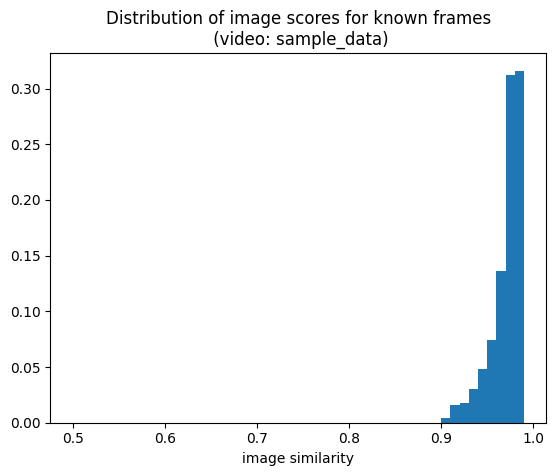

0.9053075313568115


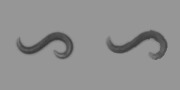

0.961417555809021


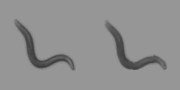

0.9733497500419617


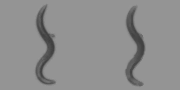

0.9787611961364746


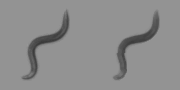

0.9940060973167419


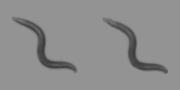

In [9]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from wormpose.commands import calibrate
from ipython_utils import ImagesViewer

video_name, result_file = next(calibrate(dataset_loader,
                                         dataset_path,
                                         worm_is_lighter=worm_is_lighter,
                                         save_images=True))

VIEW_SCORES = 5

img_viewer = ImagesViewer()
with h5py.File(result_file, "r") as f:
    scores = f['scores'][()]
    real_images = f['real_images']
    synthetic_images = f['synth_images']

    plt.hist(scores, bins=np.arange(0.5, 1, 0.01),
             weights=np.ones_like(scores)/len(scores))
    plt.xlabel("image similarity")
    plt.title(f"Distribution of image scores for known frames\n (video: {video_name})")
    plt.show()

    sorted_scores = np.argsort(scores)
    step = int(len(sorted_scores)/VIEW_SCORES)
    sorted_selection_index = [sorted_scores[0]] + sorted_scores[step:-step:step].tolist() + [sorted_scores[-1]]

    for index in sorted_selection_index:
        im = np.hstack([real_images[index], synthetic_images[index]])
        img_viewer.add_image(im)

img_viewer.view_as_list(legends=scores[sorted_selection_index])

## Build the training and evaluation dataset
We now build the training dataset which contain images such as above, saved as a binary file ".tfrecord". We also build an evaluation dataset.

We create a small training set of 1000 images for this tutorial. For a more representative training set, increase the value of num_train_samples (the default value is 500k), but the generation will take more time.

In [12]:
from wormpose.commands import generate
from ipywidgets import FloatProgress
from IPython.display import display

fp = FloatProgress(min=0., max=1.)
display(fp)

gen_progress = generate(dataset_loader,
                        dataset_path,
                        worm_is_lighter=worm_is_lighter,
                        num_train_samples=100)
for progress_value in gen_progress:
    print(progress_value)
    fp.value = progress_value

FloatProgress(value=0.0, max=1.0)

INFO:wormpose.commands.generate_training_data:
	dataset_loader: sample_data, 
	dataset_path: wormpose_data/datasets/sample_data
INFO:wormpose.commands.generate_training_data:
	worm_is_lighter: False, 
	num_train_samples: 100, 
	num_process: 2, 
	temp_dir: /tmp/tmpx655wa2a, 
	num_eval_samples: 10000, 
	work_dir: experiments, 
	postures_generation: <bound method PosturesModel.generate of <wormpose.pose.postures_model.PosturesModel object at 0x7f6839fe38f0>>, 
	video_names: None, 
	random_seed: None, 
	resize_options: <wormpose.dataset.loaders.resizer.ResizeOptions object at 0x7f68399ffe30>


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


KeyboardInterrupt: 

## Check generated tfrecord files

We check that the tfrecord files have been generated successfully by viewing the first few images.

In [ ]:
from glob import glob
import os
from wormpose.config import default_paths
from wormpose.machine_learning import tfrecord_file
from ipython_utils import ImagesViewer


def view_tfrecord(filename, theta_dims=100, max_viz=100):
    img_viewer = ImagesViewer()
    for index, record in enumerate(tfrecord_file.read(filename, theta_dims)):
        if index >= max_viz:
            break
        image_data = record[0].numpy()
        img_viewer.add_image(image_data)
    print(f"Reading: \'{filename}\' ({index} first frames)")

    img_viewer.view_as_slider()

train_records = list(sorted(glob(os.path.join(project_dir,
                                              default_paths.TRAINING_DATA_DIR,
                                              default_paths.SYNTH_TRAIN_DATASET_NAMES.format(index='*')))))
print(f"Training tfrecord files: {len(train_records)} files.")
if len(train_records) > 0 :
    view_tfrecord(train_records[0])
eval_record = list(glob(os.path.join(project_dir,
                                     default_paths.TRAINING_DATA_DIR,
                                     default_paths.REAL_EVAL_DATASET_NAMES.format(index='*'))))
if len(eval_record) > 0 :
    view_tfrecord(eval_record[0])

## Train

We train the network on the generated data.

We only train on 10 epochs for this tutorial, increase the number of epochs for better results.

In [ ]:
import tensorflow as tf
from wormpose.commands import train

if tf.test.gpu_device_name() == '':
    print("Warning, no GPU available for training, this will be very slow.")

train(dataset_path, epochs=10)

## Predict

We can now predict the full video. We use a score threshold of 0.7 to discard wrong results (see calibration to choose the value of the threshold).

In [ ]:
from wormpose.commands import predict

use_pretrained_network = True
if use_pretrained_network: # already trained model for "sample_data" only
    model_path = os.path.join('wormpose_data', 'models', 'sample_data', 'trained_model.hdf5')
else: # will use the default path for the model that was trained in the previous cell
    model_path = None

predict(dataset_path=dataset_path,
        score_threshold=0.7,
        model_path=model_path)

We visualize the result by drawing the posture skeleton on top of the original image.

In [ ]:
from wormpose.commands import visualize

visualize(dataset_path, draw_original=False)
!find -name 'images_results.zip' -exec sh -c 'unzip -o -d "${1%.*}" "$1"' _ {} \;  > /dev/null

In [ ]:
import os, glob
from wormpose.config import default_paths
from ipython_utils import ImagesViewer

MAX_FRAMES = 1000

img_filenames = sorted(glob.glob(os.path.join(project_dir, default_paths.RESULTS_DIR, '*','*','*.png')))[:MAX_FRAMES]
img_viewer = ImagesViewer()
for filename in img_filenames:
    img_viewer.add_image_filename(filename)

img_viewer.view_as_list(legends=range(len(img_filenames)))

In [22]:
import nbformat, json

# Replace with the actual filename if Colab saved differently
path = "tutorial_sample_data.ipynb"

# Load the notebook
with open(path) as f:
    nb = nbformat.read(f, as_version=4)

# Clean broken widget metadata
if "widgets" in nb["metadata"]:
    print("Removing invalid widgets metadata")
    del nb["metadata"]["widgets"]

# Save cleaned notebook
with open(path, "w") as f:
    nbformat.write(nb, f)

print("Notebook cleaned and saved:", path)


Notebook cleaned and saved: tutorial_sample_data.ipynb
